In [1]:
import os
os.chdir("../..")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *
import optuna
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

In [5]:
print("[INFO] Loading datasets...")
train_loader, val_loader, test_loader = load_datasets(
    "wildfire_dataset_scaled", batch_size=32, augmentation="augmented"
)
print("[INFO] Datasets loaded successfully!")

2024-12-24 21:51:28,804 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-24 21:51:28,804 - INFO - Applying selected augmentations for wildfire scenarios.
2024-12-24 21:51:28,813 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-24 21:51:28,815 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-24 21:51:28,817 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-24 21:51:28,819 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-24 21:51:28,820 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-24 21:51:28,821 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-24 21:51:28,822 - INFO - Class 'fire' has 730 samples.
2024-12-24 21:51:28,825 - INFO - Class 'nofire' has 1157 samples.
2024-12-24 21:51:28,826 - INFO - Computed class weights: {'fire': 1.0, 'nofire': 

[INFO] Loading datasets...


2024-12-24 21:51:40,048 - INFO - DataLoaders created successfully.


[INFO] Datasets loaded successfully!


In [6]:
def objective(trial):
    print(f"[DEBUG] Starting trial {trial.number}...")

    # Hyperparameter suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    print(f"[DEBUG] Suggested hyperparameters: lr={lr}, weight_decay={weight_decay}, optimizer={optimizer_name}")

    # Initialize model
    print("[DEBUG] Initializing mobilenet_v2 model...")
    model = initialize_model("mobilenet_v2", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=4)
    model.to(device)

    # Optimizer setup
    print("[DEBUG] Setting up optimizer...")
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    print("[INFO] Starting model training...")
    save_path = "outputs/models/tuned/mobilenet_v2_trial_best.pth"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_path=save_path,
        early_stop_patience=5,
        monitor_metric="val_f1",
    )
    print("[INFO] Training completed!")

    # Return validation recall
    val_recall = history["val_f1"][-1]
    print(f"[INFO] Trial {trial.number} - Final Validation val_f1: {val_recall:.4f}")
    return val_recall


In [7]:
# Run Optuna

import time

# Start the timer
start_time = time.time()
print("Trials started...")


print("[INFO] Running hyperparameter optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(f"[INFO] Best parameters found: {study.best_params}")

# Calculate and display elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format elapsed time as hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Trials completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")


[I 2024-12-24 21:51:40,066] A new study created in memory with name: no-name-413e85ad-1d31-4571-86a3-b4e6a6c35cd2


Trials started...
[INFO] Running hyperparameter optimization...
[DEBUG] Starting trial 0...
[DEBUG] Suggested hyperparameters: lr=0.002629804884888818, weight_decay=1.7766877067171046e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.8362
Epoch [1]: Train Loss: 0.4654, Train Acc: 0.7822 | Val Loss: 0.5723, Val Acc: 0.7662, Val Recall: 0.9756, Val F1: 0.8362


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.8588
Epoch [2]: Train Loss: 0.3517, Train Acc: 0.8622 | Val Loss: 0.5190, Val Acc: 0.8209, Val Recall: 0.8902, Val F1: 0.8588


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.8653
Epoch [3]: Train Loss: 0.2973, Train Acc: 0.8776 | Val Loss: 0.3841, Val Acc: 0.8358, Val Recall: 0.8618, Val F1: 0.8653


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.8675
Epoch [4]: Train Loss: 0.2605, Train Acc: 0.9009 | Val Loss: 0.3857, Val Acc: 0.8458, Val Recall: 0.8252, Val F1: 0.8675


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.8710
Epoch [5]: Train Loss: 0.2537, Train Acc: 0.8940 | Val Loss: 0.3527, Val Acc: 0.8408, Val Recall: 0.8780, Val F1: 0.8710


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.9031
Epoch [6]: Train Loss: 0.2414, Train Acc: 0.9009 | Val Loss: 0.3165, Val Acc: 0.8831, Val Recall: 0.8902, Val F1: 0.9031


[INFO] Learning rate adjusted to: 0.002630
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.2311, Train Acc: 0.9089 | Val Loss: 0.4018, Val Acc: 0.8284, Val Recall: 0.7683, Val F1: 0.8456


[INFO] Learning rate adjusted to: 0.002630
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.2159, Train Acc: 0.9110 | Val Loss: 0.4415, Val Acc: 0.8532, Val Recall: 0.9553, Val F1: 0.8885


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.9116
Epoch [9]: Train Loss: 0.1896, Train Acc: 0.9274 | Val Loss: 0.3176, Val Acc: 0.8905, Val Recall: 0.9228, Val F1: 0.9116


[INFO] Learning rate adjusted to: 0.002630
[INFO] Best model saved with val_f1: 0.9188
Epoch [10]: Train Loss: 0.1695, Train Acc: 0.9338 | Val Loss: 0.3130, Val Acc: 0.8980, Val Recall: 0.9431, Val F1: 0.9188


[INFO] Learning rate adjusted to: 0.002630
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.1679, Train Acc: 0.9364 | Val Loss: 0.3084, Val Acc: 0.8955, Val Recall: 0.9024, Val F1: 0.9136


[INFO] Learning rate adjusted to: 0.002630
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.1808, Train Acc: 0.9316 | Val Loss: 0.3599, Val Acc: 0.8657, Val Recall: 0.9024, Val F1: 0.8916


[INFO] Learning rate adjusted to: 0.002630
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [13]: Train Loss: 0.1432, Train Acc: 0.9401 | Val Loss: 0.3415, Val Acc: 0.8905, Val Recall: 0.9228, Val F1: 0.9116


[INFO] Learning rate adjusted to: 0.001315
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [14]: Train Loss: 0.1666, Train Acc: 0.9364 | Val Loss: 0.3845, Val Acc: 0.8806, Val Recall: 0.9106, Val F1: 0.9032


[INFO] Learning rate adjusted to: 0.001315
[INFO] Best model saved with val_f1: 0.9237
Epoch [15]: Train Loss: 0.1273, Train Acc: 0.9518 | Val Loss: 0.2540, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.001315
[INFO] Best model saved with val_f1: 0.9270
Epoch [16]: Train Loss: 0.0976, Train Acc: 0.9677 | Val Loss: 0.3238, Val Acc: 0.9080, Val Recall: 0.9553, Val F1: 0.9270


[INFO] Learning rate adjusted to: 0.001315
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [17]: Train Loss: 0.0733, Train Acc: 0.9767 | Val Loss: 0.3454, Val Acc: 0.9005, Val Recall: 0.9472, Val F1: 0.9209


[INFO] Learning rate adjusted to: 0.001315
[INFO] Best model saved with val_f1: 0.9323
Epoch [18]: Train Loss: 0.0581, Train Acc: 0.9788 | Val Loss: 0.3033, Val Acc: 0.9154, Val Recall: 0.9512, Val F1: 0.9323


[INFO] Learning rate adjusted to: 0.001315
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [19]: Train Loss: 0.0779, Train Acc: 0.9746 | Val Loss: 0.4048, Val Acc: 0.8881, Val Recall: 0.9593, Val F1: 0.9130


[INFO] Learning rate adjusted to: 0.001315
[INFO] Best model saved with val_f1: 0.9333
Epoch [20]: Train Loss: 0.0683, Train Acc: 0.9767 | Val Loss: 0.2682, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.001315
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [21]: Train Loss: 0.0759, Train Acc: 0.9687 | Val Loss: 0.3235, Val Acc: 0.8856, Val Recall: 0.8780, Val F1: 0.9038


[INFO] Learning rate adjusted to: 0.001315
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [22]: Train Loss: 0.0496, Train Acc: 0.9830 | Val Loss: 0.3252, Val Acc: 0.9055, Val Recall: 0.9675, Val F1: 0.9261


[INFO] Learning rate adjusted to: 0.001315
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [23]: Train Loss: 0.0550, Train Acc: 0.9799 | Val Loss: 0.3127, Val Acc: 0.9154, Val Recall: 0.9146, Val F1: 0.9298


[INFO] Learning rate adjusted to: 0.000657
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [24]: Train Loss: 0.0799, Train Acc: 0.9703 | Val Loss: 0.3202, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289


[I 2024-12-24 22:00:21,024] Trial 0 finished with value: 0.9282868525896414 and parameters: {'lr': 0.002629804884888818, 'weight_decay': 1.7766877067171046e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9282868525896414.


[INFO] Learning rate adjusted to: 0.000657
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [25]: Train Loss: 0.0493, Train Acc: 0.9857 | Val Loss: 0.3485, Val Acc: 0.9104, Val Recall: 0.9472, Val F1: 0.9283
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 25 epochs. Best val_f1: 0.9333

[INFO] Training completed!
[INFO] Trial 0 - Final Validation val_f1: 0.9283
[DEBUG] Starting trial 1...
[DEBUG] Suggested hyperparameters: lr=9.684079057623179e-05, weight_decay=0.000239246665856745, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.8720
Epoch [1]: Train Loss: 0.5214, Train Acc: 0.7721 | Val Loss: 0.3988, Val Acc: 0.8408, Val Recall: 0.8862, Val F1: 0.8720


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9004
Epoch [2]: Train Loss: 0.3009, Train Acc: 0.8813 | Val Loss: 0.3021, Val Acc: 0.8756, Val Recall: 0.9187, Val F1: 0.9004


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9130
Epoch [3]: Train Loss: 0.1704, Train Acc: 0.9412 | Val Loss: 0.2617, Val Acc: 0.8905, Val Recall: 0.9390, Val F1: 0.9130


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9273
Epoch [4]: Train Loss: 0.1582, Train Acc: 0.9396 | Val Loss: 0.2258, Val Acc: 0.9080, Val Recall: 0.9593, Val F1: 0.9273


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9307
Epoch [5]: Train Loss: 0.1158, Train Acc: 0.9640 | Val Loss: 0.2172, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9379
Epoch [6]: Train Loss: 0.0952, Train Acc: 0.9693 | Val Loss: 0.1963, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000097
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.0757, Train Acc: 0.9756 | Val Loss: 0.2115, Val Acc: 0.9204, Val Recall: 0.9472, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9444
Epoch [8]: Train Loss: 0.0574, Train Acc: 0.9825 | Val Loss: 0.2393, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[INFO] Learning rate adjusted to: 0.000097
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.0520, Train Acc: 0.9852 | Val Loss: 0.2738, Val Acc: 0.9055, Val Recall: 0.9634, Val F1: 0.9258


[INFO] Learning rate adjusted to: 0.000097
[INFO] Best model saved with val_f1: 0.9482
Epoch [10]: Train Loss: 0.0516, Train Acc: 0.9841 | Val Loss: 0.1901, Val Acc: 0.9353, Val Recall: 0.9675, Val F1: 0.9482


[INFO] Learning rate adjusted to: 0.000097
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.0324, Train Acc: 0.9910 | Val Loss: 0.2495, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000097
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.0389, Train Acc: 0.9889 | Val Loss: 0.2601, Val Acc: 0.9204, Val Recall: 0.9634, Val F1: 0.9368


[INFO] Learning rate adjusted to: 0.000097
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [13]: Train Loss: 0.0328, Train Acc: 0.9899 | Val Loss: 0.2427, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000048
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [14]: Train Loss: 0.0301, Train Acc: 0.9878 | Val Loss: 0.2708, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[I 2024-12-24 22:03:46,933] Trial 1 finished with value: 0.9346938775510204 and parameters: {'lr': 9.684079057623179e-05, 'weight_decay': 0.000239246665856745, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9346938775510204.


[INFO] Learning rate adjusted to: 0.000048
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [15]: Train Loss: 0.0263, Train Acc: 0.9905 | Val Loss: 0.2856, Val Acc: 0.9204, Val Recall: 0.9309, Val F1: 0.9347
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 15 epochs. Best val_f1: 0.9482

[INFO] Training completed!
[INFO] Trial 1 - Final Validation val_f1: 0.9347
[DEBUG] Starting trial 2...
[DEBUG] Suggested hyperparameters: lr=8.219588727907012e-05, weight_decay=1.374477154237569e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.8378
Epoch [1]: Train Loss: 0.5623, Train Acc: 0.7287 | Val Loss: 0.4480, Val Acc: 0.8035, Val Recall: 0.8293, Val F1: 0.8378


[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9008
Epoch [2]: Train Loss: 0.3287, Train Acc: 0.8622 | Val Loss: 0.3114, Val Acc: 0.8756, Val Recall: 0.9228, Val F1: 0.9008


[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9213
Epoch [3]: Train Loss: 0.2346, Train Acc: 0.9110 | Val Loss: 0.2550, Val Acc: 0.9005, Val Recall: 0.9512, Val F1: 0.9213


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.1675, Train Acc: 0.9364 | Val Loss: 0.2316, Val Acc: 0.9030, Val Recall: 0.9228, Val F1: 0.9209


[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9312
Epoch [5]: Train Loss: 0.1273, Train Acc: 0.9544 | Val Loss: 0.2176, Val Acc: 0.9154, Val Recall: 0.9350, Val F1: 0.9312


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.1021, Train Acc: 0.9629 | Val Loss: 0.2226, Val Acc: 0.9129, Val Recall: 0.9268, Val F1: 0.9287


[INFO] Learning rate adjusted to: 0.000082
[INFO] Best model saved with val_f1: 0.9393
Epoch [7]: Train Loss: 0.0837, Train Acc: 0.9703 | Val Loss: 0.2181, Val Acc: 0.9229, Val Recall: 0.9756, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0597, Train Acc: 0.9777 | Val Loss: 0.2245, Val Acc: 0.9229, Val Recall: 0.9268, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.0582, Train Acc: 0.9809 | Val Loss: 0.2082, Val Acc: 0.9129, Val Recall: 0.9187, Val F1: 0.9281


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.0341, Train Acc: 0.9921 | Val Loss: 0.2315, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [11]: Train Loss: 0.0443, Train Acc: 0.9889 | Val Loss: 0.2548, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[I 2024-12-24 22:06:30,044] Trial 2 finished with value: 0.9263565891472868 and parameters: {'lr': 8.219588727907012e-05, 'weight_decay': 1.374477154237569e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9346938775510204.


[INFO] Learning rate adjusted to: 0.000041
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [12]: Train Loss: 0.0464, Train Acc: 0.9836 | Val Loss: 0.2976, Val Acc: 0.9055, Val Recall: 0.9715, Val F1: 0.9264
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 12 epochs. Best val_f1: 0.9393

[INFO] Training completed!
[INFO] Trial 2 - Final Validation val_f1: 0.9264
[DEBUG] Starting trial 3...
[DEBUG] Suggested hyperparameters: lr=0.0013642733329299927, weight_decay=0.0004725597823019827, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.8336
Epoch [1]: Train Loss: 0.6069, Train Acc: 0.6730 | Val Loss: 0.5034, Val Acc: 0.7687, Val Recall: 0.9472, Val F1: 0.8336


[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.8639
Epoch [2]: Train Loss: 0.4458, Train Acc: 0.8007 | Val Loss: 0.3776, Val Acc: 0.8284, Val Recall: 0.8902, Val F1: 0.8639


[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.8685
Epoch [3]: Train Loss: 0.3487, Train Acc: 0.8548 | Val Loss: 0.3685, Val Acc: 0.8358, Val Recall: 0.8862, Val F1: 0.8685


[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.8966
Epoch [4]: Train Loss: 0.2791, Train Acc: 0.8882 | Val Loss: 0.3029, Val Acc: 0.8731, Val Recall: 0.8984, Val F1: 0.8966


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.2430, Train Acc: 0.9057 | Val Loss: 0.3168, Val Acc: 0.8532, Val Recall: 0.8984, Val F1: 0.8822


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.2149, Train Acc: 0.9136 | Val Loss: 0.2890, Val Acc: 0.8682, Val Recall: 0.9187, Val F1: 0.8950


[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.9277
Epoch [7]: Train Loss: 0.1936, Train Acc: 0.9253 | Val Loss: 0.2511, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.1809, Train Acc: 0.9300 | Val Loss: 0.2653, Val Acc: 0.8930, Val Recall: 0.9390, Val F1: 0.9149


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.1657, Train Acc: 0.9332 | Val Loss: 0.2622, Val Acc: 0.8930, Val Recall: 0.9187, Val F1: 0.9131


[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.9325
Epoch [10]: Train Loss: 0.1402, Train Acc: 0.9486 | Val Loss: 0.2388, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.1319, Train Acc: 0.9528 | Val Loss: 0.2697, Val Acc: 0.8905, Val Recall: 0.9146, Val F1: 0.9109


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.1335, Train Acc: 0.9523 | Val Loss: 0.2626, Val Acc: 0.9005, Val Recall: 0.9187, Val F1: 0.9187


[INFO] Learning rate adjusted to: 0.001364
[INFO] Best model saved with val_f1: 0.9363
Epoch [13]: Train Loss: 0.1256, Train Acc: 0.9592 | Val Loss: 0.2303, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.1079, Train Acc: 0.9624 | Val Loss: 0.2541, Val Acc: 0.9129, Val Recall: 0.9309, Val F1: 0.9290


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.1083, Train Acc: 0.9613 | Val Loss: 0.2459, Val Acc: 0.9005, Val Recall: 0.9268, Val F1: 0.9194


[INFO] Learning rate adjusted to: 0.001364
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0904, Train Acc: 0.9677 | Val Loss: 0.2345, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293


[INFO] Learning rate adjusted to: 0.000682
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0976, Train Acc: 0.9624 | Val Loss: 0.2541, Val Acc: 0.9030, Val Recall: 0.9593, Val F1: 0.9237


[I 2024-12-24 22:10:50,033] Trial 3 finished with value: 0.9267326732673268 and parameters: {'lr': 0.0013642733329299927, 'weight_decay': 0.0004725597823019827, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9346938775510204.


[INFO] Learning rate adjusted to: 0.000682
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0708, Train Acc: 0.9762 | Val Loss: 0.2195, Val Acc: 0.9080, Val Recall: 0.9512, Val F1: 0.9267
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9363

[INFO] Training completed!
[INFO] Trial 3 - Final Validation val_f1: 0.9267
[DEBUG] Starting trial 4...
[DEBUG] Suggested hyperparameters: lr=1.007500489711959e-05, weight_decay=2.6113204693980315e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.7401
Epoch [1]: Train Loss: 0.6739, Train Acc: 0.5612 | Val Loss: 0.6411, Val Acc: 0.6418, Val Recall: 0.8333, Val F1: 0.7401


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.7731
Epoch [2]: Train Loss: 0.6243, Train Acc: 0.6725 | Val Loss: 0.6114, Val Acc: 0.7065, Val Recall: 0.8171, Val F1: 0.7731


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8141
Epoch [3]: Train Loss: 0.5905, Train Acc: 0.7202 | Val Loss: 0.5726, Val Acc: 0.7512, Val Recall: 0.8902, Val F1: 0.8141


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8242
Epoch [4]: Train Loss: 0.5602, Train Acc: 0.7424 | Val Loss: 0.5465, Val Acc: 0.7761, Val Recall: 0.8577, Val F1: 0.8242


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8373
Epoch [5]: Train Loss: 0.5052, Train Acc: 0.8124 | Val Loss: 0.5114, Val Acc: 0.7960, Val Recall: 0.8577, Val F1: 0.8373


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8600
Epoch [6]: Train Loss: 0.4766, Train Acc: 0.8188 | Val Loss: 0.4820, Val Acc: 0.8259, Val Recall: 0.8740, Val F1: 0.8600


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.4603, Train Acc: 0.8140 | Val Loss: 0.4466, Val Acc: 0.8035, Val Recall: 0.8415, Val F1: 0.8398


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.4064, Train Acc: 0.8458 | Val Loss: 0.4364, Val Acc: 0.8209, Val Recall: 0.8577, Val F1: 0.8543


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.3830, Train Acc: 0.8490 | Val Loss: 0.4093, Val Acc: 0.8134, Val Recall: 0.8618, Val F1: 0.8497


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8646
Epoch [10]: Train Loss: 0.3653, Train Acc: 0.8627 | Val Loss: 0.3854, Val Acc: 0.8333, Val Recall: 0.8699, Val F1: 0.8646


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.3353, Train Acc: 0.8776 | Val Loss: 0.3671, Val Acc: 0.8358, Val Recall: 0.8537, Val F1: 0.8642


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8675
Epoch [12]: Train Loss: 0.3157, Train Acc: 0.8776 | Val Loss: 0.3714, Val Acc: 0.8358, Val Recall: 0.8780, Val F1: 0.8675


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.8884
Epoch [13]: Train Loss: 0.2967, Train Acc: 0.8871 | Val Loss: 0.3339, Val Acc: 0.8632, Val Recall: 0.8902, Val F1: 0.8884


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.2748, Train Acc: 0.9014 | Val Loss: 0.3284, Val Acc: 0.8632, Val Recall: 0.8821, Val F1: 0.8875


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.2740, Train Acc: 0.8951 | Val Loss: 0.3319, Val Acc: 0.8582, Val Recall: 0.8821, Val F1: 0.8839


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.9048
Epoch [16]: Train Loss: 0.2438, Train Acc: 0.9126 | Val Loss: 0.3079, Val Acc: 0.8806, Val Recall: 0.9268, Val F1: 0.9048


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [17]: Train Loss: 0.2445, Train Acc: 0.9099 | Val Loss: 0.2980, Val Acc: 0.8781, Val Recall: 0.9309, Val F1: 0.9034


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [18]: Train Loss: 0.2349, Train Acc: 0.9173 | Val Loss: 0.2926, Val Acc: 0.8632, Val Recall: 0.8984, Val F1: 0.8893


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [19]: Train Loss: 0.2058, Train Acc: 0.9300 | Val Loss: 0.2812, Val Acc: 0.8806, Val Recall: 0.9146, Val F1: 0.9036


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.9061
Epoch [20]: Train Loss: 0.2183, Train Acc: 0.9200 | Val Loss: 0.2699, Val Acc: 0.8856, Val Recall: 0.9024, Val F1: 0.9061


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_f1: 0.9102
Epoch [21]: Train Loss: 0.2014, Train Acc: 0.9269 | Val Loss: 0.2767, Val Acc: 0.8905, Val Recall: 0.9065, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [22]: Train Loss: 0.1951, Train Acc: 0.9332 | Val Loss: 0.2757, Val Acc: 0.8831, Val Recall: 0.9065, Val F1: 0.9047


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [23]: Train Loss: 0.1958, Train Acc: 0.9210 | Val Loss: 0.2681, Val Acc: 0.8856, Val Recall: 0.9146, Val F1: 0.9073


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [24]: Train Loss: 0.1756, Train Acc: 0.9369 | Val Loss: 0.2555, Val Acc: 0.8781, Val Recall: 0.9187, Val F1: 0.9022


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [25]: Train Loss: 0.1632, Train Acc: 0.9475 | Val Loss: 0.2652, Val Acc: 0.8856, Val Recall: 0.9228, Val F1: 0.9080


[I 2024-12-24 22:17:18,537] Trial 4 finished with value: 0.8993839835728953 and parameters: {'lr': 1.007500489711959e-05, 'weight_decay': 2.6113204693980315e-05, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.9346938775510204.


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [26]: Train Loss: 0.1826, Train Acc: 0.9279 | Val Loss: 0.2644, Val Acc: 0.8781, Val Recall: 0.8902, Val F1: 0.8994
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 26 epochs. Best val_f1: 0.9102

[INFO] Training completed!
[INFO] Trial 4 - Final Validation val_f1: 0.8994
[DEBUG] Starting trial 5...
[DEBUG] Suggested hyperparameters: lr=1.8284601621933932e-05, weight_decay=0.0007277832247944638, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.7797
Epoch [1]: Train Loss: 0.6771, Train Acc: 0.5686 | Val Loss: 0.6320, Val Acc: 0.7090, Val Recall: 0.8415, Val F1: 0.7797


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8000
Epoch [2]: Train Loss: 0.6144, Train Acc: 0.6937 | Val Loss: 0.5685, Val Acc: 0.7388, Val Recall: 0.8537, Val F1: 0.8000


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8409
Epoch [3]: Train Loss: 0.5359, Train Acc: 0.7912 | Val Loss: 0.5128, Val Acc: 0.7985, Val Recall: 0.8699, Val F1: 0.8409


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8571
Epoch [4]: Train Loss: 0.4756, Train Acc: 0.8082 | Val Loss: 0.4487, Val Acc: 0.8209, Val Recall: 0.8780, Val F1: 0.8571


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8601
Epoch [5]: Train Loss: 0.4076, Train Acc: 0.8511 | Val Loss: 0.4185, Val Acc: 0.8308, Val Recall: 0.8496, Val F1: 0.8601


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8708
Epoch [6]: Train Loss: 0.3634, Train Acc: 0.8675 | Val Loss: 0.3710, Val Acc: 0.8383, Val Recall: 0.8902, Val F1: 0.8708


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8840
Epoch [7]: Train Loss: 0.3319, Train Acc: 0.8786 | Val Loss: 0.3406, Val Acc: 0.8557, Val Recall: 0.8984, Val F1: 0.8840


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.2824, Train Acc: 0.8983 | Val Loss: 0.3262, Val Acc: 0.8532, Val Recall: 0.8902, Val F1: 0.8813


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.8976
Epoch [9]: Train Loss: 0.2733, Train Acc: 0.8967 | Val Loss: 0.3008, Val Acc: 0.8706, Val Recall: 0.9268, Val F1: 0.8976


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.2441, Train Acc: 0.9141 | Val Loss: 0.2855, Val Acc: 0.8706, Val Recall: 0.8943, Val F1: 0.8943


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.2317, Train Acc: 0.9216 | Val Loss: 0.2664, Val Acc: 0.8706, Val Recall: 0.9187, Val F1: 0.8968


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.9061
Epoch [12]: Train Loss: 0.2001, Train Acc: 0.9285 | Val Loss: 0.2551, Val Acc: 0.8856, Val Recall: 0.9024, Val F1: 0.9061


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.9173
Epoch [13]: Train Loss: 0.1938, Train Acc: 0.9348 | Val Loss: 0.2439, Val Acc: 0.8955, Val Recall: 0.9472, Val F1: 0.9173


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.9178
Epoch [14]: Train Loss: 0.1678, Train Acc: 0.9438 | Val Loss: 0.2375, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.9218
Epoch [15]: Train Loss: 0.1691, Train Acc: 0.9332 | Val Loss: 0.2366, Val Acc: 0.9030, Val Recall: 0.9350, Val F1: 0.9218


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [16]: Train Loss: 0.1505, Train Acc: 0.9444 | Val Loss: 0.2282, Val Acc: 0.8955, Val Recall: 0.9106, Val F1: 0.9143


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [17]: Train Loss: 0.1468, Train Acc: 0.9528 | Val Loss: 0.2120, Val Acc: 0.8980, Val Recall: 0.9512, Val F1: 0.9194


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_f1: 0.9357
Epoch [18]: Train Loss: 0.1314, Train Acc: 0.9523 | Val Loss: 0.2260, Val Acc: 0.9179, Val Recall: 0.9756, Val F1: 0.9357


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [19]: Train Loss: 0.1346, Train Acc: 0.9502 | Val Loss: 0.2078, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [20]: Train Loss: 0.1165, Train Acc: 0.9650 | Val Loss: 0.2171, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[INFO] Learning rate adjusted to: 0.000018
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [21]: Train Loss: 0.1013, Train Acc: 0.9677 | Val Loss: 0.2146, Val Acc: 0.9030, Val Recall: 0.9309, Val F1: 0.9215


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [22]: Train Loss: 0.0930, Train Acc: 0.9730 | Val Loss: 0.1972, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_f1: 0.9386
Epoch [23]: Train Loss: 0.1023, Train Acc: 0.9682 | Val Loss: 0.1993, Val Acc: 0.9229, Val Recall: 0.9634, Val F1: 0.9386


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [24]: Train Loss: 0.0864, Train Acc: 0.9724 | Val Loss: 0.2053, Val Acc: 0.9179, Val Recall: 0.9634, Val F1: 0.9349


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [25]: Train Loss: 0.0859, Train Acc: 0.9756 | Val Loss: 0.1934, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [26]: Train Loss: 0.0855, Train Acc: 0.9693 | Val Loss: 0.2061, Val Acc: 0.9179, Val Recall: 0.9675, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [27]: Train Loss: 0.0769, Train Acc: 0.9777 | Val Loss: 0.2449, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000005
[INFO] Best model saved with val_f1: 0.9459
Epoch [28]: Train Loss: 0.0838, Train Acc: 0.9714 | Val Loss: 0.1839, Val Acc: 0.9328, Val Recall: 0.9593, Val F1: 0.9459


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [29]: Train Loss: 0.0768, Train Acc: 0.9714 | Val Loss: 0.2178, Val Acc: 0.9179, Val Recall: 0.9675, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [30]: Train Loss: 0.0770, Train Acc: 0.9788 | Val Loss: 0.2126, Val Acc: 0.9080, Val Recall: 0.9593, Val F1: 0.9273


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [31]: Train Loss: 0.0852, Train Acc: 0.9714 | Val Loss: 0.2054, Val Acc: 0.9229, Val Recall: 0.9675, Val F1: 0.9389


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [32]: Train Loss: 0.0727, Train Acc: 0.9767 | Val Loss: 0.2094, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341


[I 2024-12-24 22:25:00,741] Trial 5 finished with value: 0.9354838709677419 and parameters: {'lr': 1.8284601621933932e-05, 'weight_decay': 0.0007277832247944638, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.9354838709677419.


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [33]: Train Loss: 0.0725, Train Acc: 0.9815 | Val Loss: 0.1976, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 33 epochs. Best val_f1: 0.9459

[INFO] Training completed!
[INFO] Trial 5 - Final Validation val_f1: 0.9355
[DEBUG] Starting trial 6...
[DEBUG] Suggested hyperparameters: lr=0.0009616178743923452, weight_decay=0.0005186529658319264, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000962
[INFO] Best model saved with val_f1: 0.8821
Epoch [1]: Train Loss: 0.3122, Train Acc: 0.8665 | Val Loss: 0.3880, Val Acc: 0.8557, Val Recall: 0.8821, Val F1: 0.8821


[INFO] Learning rate adjusted to: 0.000962
[INFO] Best model saved with val_f1: 0.8988
Epoch [2]: Train Loss: 0.2291, Train Acc: 0.9163 | Val Loss: 0.3604, Val Acc: 0.8706, Val Recall: 0.9390, Val F1: 0.8988


[INFO] Learning rate adjusted to: 0.000962
[INFO] Best model saved with val_f1: 0.9207
Epoch [3]: Train Loss: 0.1762, Train Acc: 0.9332 | Val Loss: 0.3096, Val Acc: 0.8980, Val Recall: 0.9675, Val F1: 0.9207


[INFO] Learning rate adjusted to: 0.000962
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.1161, Train Acc: 0.9608 | Val Loss: 0.3107, Val Acc: 0.8856, Val Recall: 0.8902, Val F1: 0.9050


[INFO] Learning rate adjusted to: 0.000962
[INFO] Best model saved with val_f1: 0.9328
Epoch [5]: Train Loss: 0.1251, Train Acc: 0.9544 | Val Loss: 0.2548, Val Acc: 0.9179, Val Recall: 0.9309, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000962
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.1098, Train Acc: 0.9634 | Val Loss: 0.3242, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[INFO] Learning rate adjusted to: 0.000962
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.1437, Train Acc: 0.9528 | Val Loss: 0.3377, Val Acc: 0.8657, Val Recall: 0.8943, Val F1: 0.8907


[INFO] Learning rate adjusted to: 0.000962
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0953, Train Acc: 0.9645 | Val Loss: 0.3582, Val Acc: 0.8632, Val Recall: 0.8374, Val F1: 0.8822


[INFO] Learning rate adjusted to: 0.000481
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.1022, Train Acc: 0.9640 | Val Loss: 0.3564, Val Acc: 0.8781, Val Recall: 0.9146, Val F1: 0.9018


[I 2024-12-24 22:27:19,793] Trial 6 finished with value: 0.9261477045908184 and parameters: {'lr': 0.0009616178743923452, 'weight_decay': 0.0005186529658319264, 'optimizer': 'AdamW'}. Best is trial 5 with value: 0.9354838709677419.


[INFO] Learning rate adjusted to: 0.000481
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.0863, Train Acc: 0.9714 | Val Loss: 0.2377, Val Acc: 0.9080, Val Recall: 0.9431, Val F1: 0.9261
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.9328

[INFO] Training completed!
[INFO] Trial 6 - Final Validation val_f1: 0.9261
[DEBUG] Starting trial 7...
[DEBUG] Suggested hyperparameters: lr=6.654380065069004e-05, weight_decay=7.774955029577098e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.8477
Epoch [1]: Train Loss: 0.6014, Train Acc: 0.6863 | Val Loss: 0.4924, Val Acc: 0.8060, Val Recall: 0.8821, Val F1: 0.8477


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.8943
Epoch [2]: Train Loss: 0.4025, Train Acc: 0.8405 | Val Loss: 0.3416, Val Acc: 0.8706, Val Recall: 0.8943, Val F1: 0.8943


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.8990
Epoch [3]: Train Loss: 0.2756, Train Acc: 0.8956 | Val Loss: 0.2813, Val Acc: 0.8731, Val Recall: 0.9228, Val F1: 0.8990


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.9173
Epoch [4]: Train Loss: 0.2119, Train Acc: 0.9232 | Val Loss: 0.2208, Val Acc: 0.8955, Val Recall: 0.9472, Val F1: 0.9173


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.9187
Epoch [5]: Train Loss: 0.1617, Train Acc: 0.9438 | Val Loss: 0.2203, Val Acc: 0.9005, Val Recall: 0.9187, Val F1: 0.9187


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.9315
Epoch [6]: Train Loss: 0.1311, Train Acc: 0.9502 | Val Loss: 0.2104, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.9339
Epoch [7]: Train Loss: 0.1077, Train Acc: 0.9687 | Val Loss: 0.2077, Val Acc: 0.9179, Val Recall: 0.9472, Val F1: 0.9339


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0763, Train Acc: 0.9793 | Val Loss: 0.2143, Val Acc: 0.9179, Val Recall: 0.9309, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.0845, Train Acc: 0.9746 | Val Loss: 0.2028, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.0655, Train Acc: 0.9772 | Val Loss: 0.2122, Val Acc: 0.9055, Val Recall: 0.9228, Val F1: 0.9228


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.9355
Epoch [11]: Train Loss: 0.0702, Train Acc: 0.9751 | Val Loss: 0.2038, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [12]: Train Loss: 0.0444, Train Acc: 0.9873 | Val Loss: 0.2219, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000067
[INFO] Best model saved with val_f1: 0.9393
Epoch [13]: Train Loss: 0.0367, Train Acc: 0.9905 | Val Loss: 0.2083, Val Acc: 0.9254, Val Recall: 0.9431, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0411, Train Acc: 0.9883 | Val Loss: 0.2483, Val Acc: 0.9229, Val Recall: 0.9431, Val F1: 0.9374


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0353, Train Acc: 0.9889 | Val Loss: 0.2763, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000067
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0265, Train Acc: 0.9942 | Val Loss: 0.2305, Val Acc: 0.9129, Val Recall: 0.9472, Val F1: 0.9301


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0337, Train Acc: 0.9889 | Val Loss: 0.2637, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[I 2024-12-24 22:31:27,291] Trial 7 finished with value: 0.9383697813121272 and parameters: {'lr': 6.654380065069004e-05, 'weight_decay': 7.774955029577098e-05, 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.9383697813121272.


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0264, Train Acc: 0.9947 | Val Loss: 0.2497, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9393

[INFO] Training completed!
[INFO] Trial 7 - Final Validation val_f1: 0.9384
[DEBUG] Starting trial 8...
[DEBUG] Suggested hyperparameters: lr=0.007966024102455864, weight_decay=7.397631103841994e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.007966
[INFO] Best model saved with val_f1: 0.5304
Epoch [1]: Train Loss: 0.7132, Train Acc: 0.6094 | Val Loss: 0.8936, Val Acc: 0.5771, Val Recall: 0.3902, Val F1: 0.5304


[INFO] Learning rate adjusted to: 0.007966
[INFO] Best model saved with val_f1: 0.5700
Epoch [2]: Train Loss: 0.6254, Train Acc: 0.6773 | Val Loss: 0.8721, Val Acc: 0.5572, Val Recall: 0.4797, Val F1: 0.5700


[INFO] Learning rate adjusted to: 0.007966
[INFO] Best model saved with val_f1: 0.6005
Epoch [3]: Train Loss: 0.6301, Train Acc: 0.6635 | Val Loss: 0.8632, Val Acc: 0.6194, Val Recall: 0.4675, Val F1: 0.6005


[INFO] Learning rate adjusted to: 0.007966
[INFO] Best model saved with val_f1: 0.7947
Epoch [4]: Train Loss: 0.5296, Train Acc: 0.7446 | Val Loss: 0.5890, Val Acc: 0.6915, Val Recall: 0.9756, Val F1: 0.7947


[INFO] Learning rate adjusted to: 0.007966
[INFO] Best model saved with val_f1: 0.8015
Epoch [5]: Train Loss: 0.5096, Train Acc: 0.7727 | Val Loss: 0.5470, Val Acc: 0.7363, Val Recall: 0.8699, Val F1: 0.8015


[INFO] Learning rate adjusted to: 0.007966
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.4715, Train Acc: 0.7965 | Val Loss: 0.5674, Val Acc: 0.7139, Val Recall: 0.7317, Val F1: 0.7579


[INFO] Learning rate adjusted to: 0.007966
[INFO] Best model saved with val_f1: 0.8330
Epoch [7]: Train Loss: 0.4506, Train Acc: 0.7997 | Val Loss: 0.4755, Val Acc: 0.7935, Val Recall: 0.8415, Val F1: 0.8330


[INFO] Learning rate adjusted to: 0.007966
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.5011, Train Acc: 0.7753 | Val Loss: 0.6069, Val Acc: 0.6144, Val Recall: 1.0000, Val F1: 0.7604


[INFO] Learning rate adjusted to: 0.007966
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.4966, Train Acc: 0.7668 | Val Loss: 0.6511, Val Acc: 0.7040, Val Recall: 0.9512, Val F1: 0.7973


[INFO] Learning rate adjusted to: 0.007966
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.4704, Train Acc: 0.7901 | Val Loss: 0.4798, Val Acc: 0.7562, Val Recall: 0.8089, Val F1: 0.8024


[INFO] Learning rate adjusted to: 0.003983
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [11]: Train Loss: 0.4407, Train Acc: 0.7992 | Val Loss: 0.7727, Val Acc: 0.7139, Val Recall: 0.9431, Val F1: 0.8014


[INFO] Learning rate adjusted to: 0.003983
[INFO] Best model saved with val_f1: 0.8599
Epoch [12]: Train Loss: 0.4149, Train Acc: 0.8256 | Val Loss: 0.4178, Val Acc: 0.8209, Val Recall: 0.8984, Val F1: 0.8599


[INFO] Learning rate adjusted to: 0.003983
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.3741, Train Acc: 0.8405 | Val Loss: 0.4092, Val Acc: 0.8159, Val Recall: 0.8984, Val F1: 0.8566


[INFO] Learning rate adjusted to: 0.003983
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [14]: Train Loss: 0.3940, Train Acc: 0.8299 | Val Loss: 0.4454, Val Acc: 0.8134, Val Recall: 0.9228, Val F1: 0.8582


[INFO] Learning rate adjusted to: 0.003983
[INFO] Best model saved with val_f1: 0.8768
Epoch [15]: Train Loss: 0.3498, Train Acc: 0.8500 | Val Loss: 0.3682, Val Acc: 0.8532, Val Recall: 0.8537, Val F1: 0.8768


[INFO] Learning rate adjusted to: 0.003983
[INFO] Best model saved with val_f1: 0.8802
Epoch [16]: Train Loss: 0.3867, Train Acc: 0.8320 | Val Loss: 0.4218, Val Acc: 0.8483, Val Recall: 0.9106, Val F1: 0.8802


[INFO] Learning rate adjusted to: 0.003983
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [17]: Train Loss: 0.3585, Train Acc: 0.8463 | Val Loss: 0.3980, Val Acc: 0.8358, Val Recall: 0.9228, Val F1: 0.8731


[INFO] Learning rate adjusted to: 0.003983
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [18]: Train Loss: 0.3336, Train Acc: 0.8680 | Val Loss: 0.4474, Val Acc: 0.8060, Val Recall: 0.9268, Val F1: 0.8539


[INFO] Learning rate adjusted to: 0.003983
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [19]: Train Loss: 0.3708, Train Acc: 0.8537 | Val Loss: 0.4759, Val Acc: 0.7886, Val Recall: 0.9228, Val F1: 0.8423


[INFO] Learning rate adjusted to: 0.001992
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [20]: Train Loss: 0.3515, Train Acc: 0.8479 | Val Loss: 0.3910, Val Acc: 0.8308, Val Recall: 0.9065, Val F1: 0.8677


[I 2024-12-24 22:36:16,018] Trial 8 finished with value: 0.8714859437751004 and parameters: {'lr': 0.007966024102455864, 'weight_decay': 7.397631103841994e-05, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.9383697813121272.


[INFO] Learning rate adjusted to: 0.001992
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [21]: Train Loss: 0.2987, Train Acc: 0.8786 | Val Loss: 0.4203, Val Acc: 0.8408, Val Recall: 0.8821, Val F1: 0.8715
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 21 epochs. Best val_f1: 0.8802

[INFO] Training completed!
[INFO] Trial 8 - Final Validation val_f1: 0.8715
[DEBUG] Starting trial 9...
[DEBUG] Suggested hyperparameters: lr=0.0008599797381586817, weight_decay=7.063148976199562e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.8841
Epoch [1]: Train Loss: 0.2928, Train Acc: 0.8686 | Val Loss: 0.3532, Val Acc: 0.8532, Val Recall: 0.9146, Val F1: 0.8841


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.8944
Epoch [2]: Train Loss: 0.2011, Train Acc: 0.9290 | Val Loss: 0.3792, Val Acc: 0.8731, Val Recall: 0.8780, Val F1: 0.8944


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9000
Epoch [3]: Train Loss: 0.1555, Train Acc: 0.9470 | Val Loss: 0.2979, Val Acc: 0.8756, Val Recall: 0.9146, Val F1: 0.9000


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9160
Epoch [4]: Train Loss: 0.1254, Train Acc: 0.9560 | Val Loss: 0.3441, Val Acc: 0.9005, Val Recall: 0.8862, Val F1: 0.9160


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.1075, Train Acc: 0.9656 | Val Loss: 0.4232, Val Acc: 0.8806, Val Recall: 0.9512, Val F1: 0.9070


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.0904, Train Acc: 0.9666 | Val Loss: 0.3277, Val Acc: 0.8756, Val Recall: 0.8862, Val F1: 0.8971


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9163
Epoch [7]: Train Loss: 0.0997, Train Acc: 0.9677 | Val Loss: 0.2777, Val Acc: 0.8955, Val Recall: 0.9350, Val F1: 0.9163


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9194
Epoch [8]: Train Loss: 0.0694, Train Acc: 0.9756 | Val Loss: 0.3637, Val Acc: 0.8980, Val Recall: 0.9512, Val F1: 0.9194


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9215
Epoch [9]: Train Loss: 0.0798, Train Acc: 0.9735 | Val Loss: 0.3066, Val Acc: 0.9055, Val Recall: 0.9065, Val F1: 0.9215


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.1080, Train Acc: 0.9634 | Val Loss: 0.2682, Val Acc: 0.8905, Val Recall: 0.9472, Val F1: 0.9137


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [11]: Train Loss: 0.0710, Train Acc: 0.9762 | Val Loss: 0.4018, Val Acc: 0.8756, Val Recall: 0.9350, Val F1: 0.9020


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [12]: Train Loss: 0.0685, Train Acc: 0.9783 | Val Loss: 0.3326, Val Acc: 0.9005, Val Recall: 0.9309, Val F1: 0.9197


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [13]: Train Loss: 0.0697, Train Acc: 0.9740 | Val Loss: 0.3519, Val Acc: 0.9030, Val Recall: 0.9268, Val F1: 0.9212


[INFO] Learning rate adjusted to: 0.000430
[INFO] Best model saved with val_f1: 0.9350
Epoch [14]: Train Loss: 0.0431, Train Acc: 0.9852 | Val Loss: 0.2672, Val Acc: 0.9204, Val Recall: 0.9350, Val F1: 0.9350


[INFO] Learning rate adjusted to: 0.000430
[INFO] Best model saved with val_f1: 0.9419
Epoch [15]: Train Loss: 0.0235, Train Acc: 0.9921 | Val Loss: 0.2863, Val Acc: 0.9279, Val Recall: 0.9553, Val F1: 0.9419


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [16]: Train Loss: 0.0165, Train Acc: 0.9952 | Val Loss: 0.3027, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [17]: Train Loss: 0.0232, Train Acc: 0.9926 | Val Loss: 0.3526, Val Acc: 0.9104, Val Recall: 0.9634, Val F1: 0.9294


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [18]: Train Loss: 0.0180, Train Acc: 0.9936 | Val Loss: 0.3231, Val Acc: 0.9154, Val Recall: 0.9593, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000215
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [19]: Train Loss: 0.0082, Train Acc: 0.9974 | Val Loss: 0.3695, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[I 2024-12-24 22:40:57,736] Trial 9 finished with value: 0.9390962671905697 and parameters: {'lr': 0.0008599797381586817, 'weight_decay': 7.063148976199562e-05, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000215
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [20]: Train Loss: 0.0076, Train Acc: 0.9968 | Val Loss: 0.4168, Val Acc: 0.9229, Val Recall: 0.9715, Val F1: 0.9391
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 20 epochs. Best val_f1: 0.9419

[INFO] Training completed!
[INFO] Trial 9 - Final Validation val_f1: 0.9391
[DEBUG] Starting trial 10...
[DEBUG] Suggested hyperparameters: lr=0.0003900625974525663, weight_decay=4.141590001662008e-05, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8014
Epoch [1]: Train Loss: 0.6618, Train Acc: 0.6015 | Val Loss: 0.6154, Val Acc: 0.7239, Val Recall: 0.9106, Val F1: 0.8014


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8333
Epoch [2]: Train Loss: 0.5826, Train Acc: 0.7281 | Val Loss: 0.5417, Val Acc: 0.7811, Val Recall: 0.8943, Val F1: 0.8333


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8367
Epoch [3]: Train Loss: 0.5198, Train Acc: 0.7758 | Val Loss: 0.5066, Val Acc: 0.8010, Val Recall: 0.8333, Val F1: 0.8367


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8417
Epoch [4]: Train Loss: 0.4565, Train Acc: 0.8235 | Val Loss: 0.4461, Val Acc: 0.8035, Val Recall: 0.8537, Val F1: 0.8417


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8583
Epoch [5]: Train Loss: 0.4191, Train Acc: 0.8235 | Val Loss: 0.4095, Val Acc: 0.8209, Val Recall: 0.8862, Val F1: 0.8583


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8755
Epoch [6]: Train Loss: 0.3923, Train Acc: 0.8315 | Val Loss: 0.3797, Val Acc: 0.8458, Val Recall: 0.8862, Val F1: 0.8755


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.3551, Train Acc: 0.8564 | Val Loss: 0.3790, Val Acc: 0.8408, Val Recall: 0.9146, Val F1: 0.8755


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.8990
Epoch [8]: Train Loss: 0.3431, Train Acc: 0.8437 | Val Loss: 0.3642, Val Acc: 0.8731, Val Recall: 0.9228, Val F1: 0.8990


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.3115, Train Acc: 0.8760 | Val Loss: 0.3333, Val Acc: 0.8582, Val Recall: 0.8943, Val F1: 0.8853


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.2999, Train Acc: 0.8808 | Val Loss: 0.3173, Val Acc: 0.8607, Val Recall: 0.9065, Val F1: 0.8884


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.2930, Train Acc: 0.8802 | Val Loss: 0.3033, Val Acc: 0.8756, Val Recall: 0.8902, Val F1: 0.8975


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.9012
Epoch [12]: Train Loss: 0.2600, Train Acc: 0.8961 | Val Loss: 0.3057, Val Acc: 0.8756, Val Recall: 0.9268, Val F1: 0.9012


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.9091
Epoch [13]: Train Loss: 0.2409, Train Acc: 0.9046 | Val Loss: 0.2826, Val Acc: 0.8881, Val Recall: 0.9146, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.9109
Epoch [14]: Train Loss: 0.2452, Train Acc: 0.8972 | Val Loss: 0.2709, Val Acc: 0.8905, Val Recall: 0.9146, Val F1: 0.9109


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.9124
Epoch [15]: Train Loss: 0.2323, Train Acc: 0.9046 | Val Loss: 0.2745, Val Acc: 0.8930, Val Recall: 0.9106, Val F1: 0.9124


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.9178
Epoch [16]: Train Loss: 0.2331, Train Acc: 0.9110 | Val Loss: 0.2732, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[INFO] Learning rate adjusted to: 0.000390
[INFO] Best model saved with val_f1: 0.9225
Epoch [17]: Train Loss: 0.2356, Train Acc: 0.9041 | Val Loss: 0.2541, Val Acc: 0.9030, Val Recall: 0.9431, Val F1: 0.9225


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [18]: Train Loss: 0.2243, Train Acc: 0.9099 | Val Loss: 0.2785, Val Acc: 0.8881, Val Recall: 0.9228, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [19]: Train Loss: 0.1994, Train Acc: 0.9274 | Val Loss: 0.2501, Val Acc: 0.8955, Val Recall: 0.9065, Val F1: 0.9139


[INFO] Learning rate adjusted to: 0.000390
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [20]: Train Loss: 0.1951, Train Acc: 0.9295 | Val Loss: 0.2631, Val Acc: 0.8955, Val Recall: 0.9390, Val F1: 0.9167


[INFO] Learning rate adjusted to: 0.000195
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [21]: Train Loss: 0.1920, Train Acc: 0.9258 | Val Loss: 0.2427, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[INFO] Learning rate adjusted to: 0.000195
[INFO] Best model saved with val_f1: 0.9325
Epoch [22]: Train Loss: 0.1696, Train Acc: 0.9359 | Val Loss: 0.2307, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000195
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [23]: Train Loss: 0.1719, Train Acc: 0.9332 | Val Loss: 0.2390, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206


[INFO] Learning rate adjusted to: 0.000195
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [24]: Train Loss: 0.1672, Train Acc: 0.9375 | Val Loss: 0.2346, Val Acc: 0.9104, Val Recall: 0.9431, Val F1: 0.9280


[INFO] Learning rate adjusted to: 0.000195
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [25]: Train Loss: 0.1729, Train Acc: 0.9327 | Val Loss: 0.2540, Val Acc: 0.9005, Val Recall: 0.9309, Val F1: 0.9197


[INFO] Learning rate adjusted to: 0.000098
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [26]: Train Loss: 0.1663, Train Acc: 0.9359 | Val Loss: 0.2367, Val Acc: 0.9055, Val Recall: 0.9431, Val F1: 0.9243


[I 2024-12-24 22:47:08,855] Trial 10 finished with value: 0.9224489795918367 and parameters: {'lr': 0.0003900625974525663, 'weight_decay': 4.141590001662008e-05, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000098
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [27]: Train Loss: 0.1593, Train Acc: 0.9406 | Val Loss: 0.2356, Val Acc: 0.9055, Val Recall: 0.9187, Val F1: 0.9224
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 27 epochs. Best val_f1: 0.9325

[INFO] Training completed!
[INFO] Trial 10 - Final Validation val_f1: 0.9224
[DEBUG] Starting trial 11...
[DEBUG] Suggested hyperparameters: lr=0.00010077301792908875, weight_decay=0.00013191428753385825, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.8560
Epoch [1]: Train Loss: 0.5306, Train Acc: 0.7515 | Val Loss: 0.4035, Val Acc: 0.8234, Val Recall: 0.8577, Val F1: 0.8560


[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.8946
Epoch [2]: Train Loss: 0.2941, Train Acc: 0.8829 | Val Loss: 0.2839, Val Acc: 0.8682, Val Recall: 0.9146, Val F1: 0.8946


[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.9105
Epoch [3]: Train Loss: 0.1858, Train Acc: 0.9285 | Val Loss: 0.2457, Val Acc: 0.8881, Val Recall: 0.9309, Val F1: 0.9105


[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.9240
Epoch [4]: Train Loss: 0.1537, Train Acc: 0.9475 | Val Loss: 0.2603, Val Acc: 0.9080, Val Recall: 0.9146, Val F1: 0.9240


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.1075, Train Acc: 0.9656 | Val Loss: 0.2467, Val Acc: 0.8980, Val Recall: 0.9675, Val F1: 0.9207


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.0805, Train Acc: 0.9719 | Val Loss: 0.2361, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [7]: Train Loss: 0.0693, Train Acc: 0.9762 | Val Loss: 0.2627, Val Acc: 0.9055, Val Recall: 0.9228, Val F1: 0.9228


[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.9371
Epoch [8]: Train Loss: 0.0568, Train Acc: 0.9788 | Val Loss: 0.2382, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.0559, Train Acc: 0.9841 | Val Loss: 0.2463, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.0411, Train Acc: 0.9889 | Val Loss: 0.2759, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.0457, Train Acc: 0.9868 | Val Loss: 0.2477, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.9389
Epoch [12]: Train Loss: 0.0409, Train Acc: 0.9868 | Val Loss: 0.2298, Val Acc: 0.9229, Val Recall: 0.9675, Val F1: 0.9389


[INFO] Learning rate adjusted to: 0.000101
[INFO] Best model saved with val_f1: 0.9510
Epoch [13]: Train Loss: 0.0245, Train Acc: 0.9942 | Val Loss: 0.2188, Val Acc: 0.9403, Val Recall: 0.9472, Val F1: 0.9510


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0263, Train Acc: 0.9915 | Val Loss: 0.2573, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0217, Train Acc: 0.9931 | Val Loss: 0.3034, Val Acc: 0.9129, Val Recall: 0.9715, Val F1: 0.9318


[INFO] Learning rate adjusted to: 0.000101
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0183, Train Acc: 0.9952 | Val Loss: 0.3077, Val Acc: 0.9129, Val Recall: 0.9390, Val F1: 0.9296


[INFO] Learning rate adjusted to: 0.000050
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0251, Train Acc: 0.9883 | Val Loss: 0.2992, Val Acc: 0.9154, Val Recall: 0.9593, Val F1: 0.9328


[I 2024-12-24 22:51:18,549] Trial 11 finished with value: 0.9298597194388778 and parameters: {'lr': 0.00010077301792908875, 'weight_decay': 0.00013191428753385825, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000050
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0187, Train Acc: 0.9942 | Val Loss: 0.2862, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9510

[INFO] Training completed!
[INFO] Trial 11 - Final Validation val_f1: 0.9299
[DEBUG] Starting trial 12...
[DEBUG] Suggested hyperparameters: lr=0.0003372601310010959, weight_decay=7.614979837080608e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000337
[INFO] Best model saved with val_f1: 0.9034
Epoch [1]: Train Loss: 0.3697, Train Acc: 0.8315 | Val Loss: 0.2746, Val Acc: 0.8781, Val Recall: 0.9309, Val F1: 0.9034


[INFO] Learning rate adjusted to: 0.000337
[INFO] Best model saved with val_f1: 0.9157
Epoch [2]: Train Loss: 0.1759, Train Acc: 0.9343 | Val Loss: 0.2850, Val Acc: 0.8955, Val Recall: 0.9268, Val F1: 0.9157


[INFO] Learning rate adjusted to: 0.000337
[INFO] Best model saved with val_f1: 0.9253
Epoch [3]: Train Loss: 0.1327, Train Acc: 0.9528 | Val Loss: 0.2812, Val Acc: 0.9080, Val Recall: 0.9309, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000337
[INFO] Best model saved with val_f1: 0.9281
Epoch [4]: Train Loss: 0.0934, Train Acc: 0.9740 | Val Loss: 0.2507, Val Acc: 0.9129, Val Recall: 0.9187, Val F1: 0.9281


[INFO] Learning rate adjusted to: 0.000337
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.0676, Train Acc: 0.9772 | Val Loss: 0.2922, Val Acc: 0.9080, Val Recall: 0.9634, Val F1: 0.9276


[INFO] Learning rate adjusted to: 0.000337
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [6]: Train Loss: 0.0572, Train Acc: 0.9830 | Val Loss: 0.3481, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000337
[INFO] Best model saved with val_f1: 0.9341
Epoch [7]: Train Loss: 0.0361, Train Acc: 0.9873 | Val Loss: 0.2871, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341


[INFO] Learning rate adjusted to: 0.000337
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.0571, Train Acc: 0.9799 | Val Loss: 0.3997, Val Acc: 0.9005, Val Recall: 0.9065, Val F1: 0.9177


[INFO] Learning rate adjusted to: 0.000337
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [9]: Train Loss: 0.0599, Train Acc: 0.9777 | Val Loss: 0.3439, Val Acc: 0.8980, Val Recall: 0.9675, Val F1: 0.9207


[INFO] Learning rate adjusted to: 0.000337
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [10]: Train Loss: 0.0382, Train Acc: 0.9862 | Val Loss: 0.3274, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[INFO] Learning rate adjusted to: 0.000169
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [11]: Train Loss: 0.0325, Train Acc: 0.9862 | Val Loss: 0.3585, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[I 2024-12-24 22:54:05,625] Trial 12 finished with value: 0.9306930693069307 and parameters: {'lr': 0.0003372601310010959, 'weight_decay': 7.614979837080608e-05, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000169
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [12]: Train Loss: 0.0225, Train Acc: 0.9936 | Val Loss: 0.3228, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 12 epochs. Best val_f1: 0.9341

[INFO] Training completed!
[INFO] Trial 12 - Final Validation val_f1: 0.9307
[DEBUG] Starting trial 13...
[DEBUG] Suggested hyperparameters: lr=3.377489130769599e-05, weight_decay=0.00015851647338743492, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.7919
Epoch [1]: Train Loss: 0.6340, Train Acc: 0.6534 | Val Loss: 0.5776, Val Acc: 0.7438, Val Recall: 0.7967, Val F1: 0.7919


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.8291
Epoch [2]: Train Loss: 0.5072, Train Acc: 0.8002 | Val Loss: 0.4707, Val Acc: 0.8010, Val Recall: 0.7886, Val F1: 0.8291


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.8740
Epoch [3]: Train Loss: 0.4115, Train Acc: 0.8283 | Val Loss: 0.3878, Val Acc: 0.8408, Val Recall: 0.9024, Val F1: 0.8740


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.8789
Epoch [4]: Train Loss: 0.3295, Train Acc: 0.8760 | Val Loss: 0.3398, Val Acc: 0.8532, Val Recall: 0.8699, Val F1: 0.8789


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.8998
Epoch [5]: Train Loss: 0.2691, Train Acc: 0.9094 | Val Loss: 0.3145, Val Acc: 0.8781, Val Recall: 0.8943, Val F1: 0.8998


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9080
Epoch [6]: Train Loss: 0.2443, Train Acc: 0.9014 | Val Loss: 0.2565, Val Acc: 0.8856, Val Recall: 0.9228, Val F1: 0.9080


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9127
Epoch [7]: Train Loss: 0.1996, Train Acc: 0.9274 | Val Loss: 0.2615, Val Acc: 0.8905, Val Recall: 0.9350, Val F1: 0.9127


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9150
Epoch [8]: Train Loss: 0.1813, Train Acc: 0.9353 | Val Loss: 0.2557, Val Acc: 0.8955, Val Recall: 0.9187, Val F1: 0.9150


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9178
Epoch [9]: Train Loss: 0.1521, Train Acc: 0.9449 | Val Loss: 0.2405, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9289
Epoch [10]: Train Loss: 0.1317, Train Acc: 0.9544 | Val Loss: 0.2250, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289


[INFO] Learning rate adjusted to: 0.000034
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.1088, Train Acc: 0.9634 | Val Loss: 0.2290, Val Acc: 0.9030, Val Recall: 0.9146, Val F1: 0.9202


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9317
Epoch [12]: Train Loss: 0.1104, Train Acc: 0.9645 | Val Loss: 0.2075, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000034
[INFO] Best model saved with val_f1: 0.9416
Epoch [13]: Train Loss: 0.0890, Train Acc: 0.9730 | Val Loss: 0.2068, Val Acc: 0.9279, Val Recall: 0.9512, Val F1: 0.9416


[INFO] Learning rate adjusted to: 0.000034
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0856, Train Acc: 0.9740 | Val Loss: 0.2314, Val Acc: 0.9080, Val Recall: 0.9309, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000034
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0882, Train Acc: 0.9703 | Val Loss: 0.2123, Val Acc: 0.9154, Val Recall: 0.9512, Val F1: 0.9323


[INFO] Learning rate adjusted to: 0.000034
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0857, Train Acc: 0.9751 | Val Loss: 0.2320, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000017
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0731, Train Acc: 0.9767 | Val Loss: 0.2079, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000017
[INFO] Best model saved with val_f1: 0.9457
Epoch [18]: Train Loss: 0.0590, Train Acc: 0.9846 | Val Loss: 0.2187, Val Acc: 0.9328, Val Recall: 0.9553, Val F1: 0.9457


[INFO] Learning rate adjusted to: 0.000017
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [19]: Train Loss: 0.0567, Train Acc: 0.9815 | Val Loss: 0.2150, Val Acc: 0.9229, Val Recall: 0.9715, Val F1: 0.9391


[INFO] Learning rate adjusted to: 0.000017
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [20]: Train Loss: 0.0643, Train Acc: 0.9804 | Val Loss: 0.2200, Val Acc: 0.9154, Val Recall: 0.9593, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000017
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [21]: Train Loss: 0.0545, Train Acc: 0.9868 | Val Loss: 0.2293, Val Acc: 0.9154, Val Recall: 0.9675, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [22]: Train Loss: 0.0548, Train Acc: 0.9841 | Val Loss: 0.2308, Val Acc: 0.9229, Val Recall: 0.9634, Val F1: 0.9386


[I 2024-12-24 22:59:22,272] Trial 13 finished with value: 0.9304174950298211 and parameters: {'lr': 3.377489130769599e-05, 'weight_decay': 0.00015851647338743492, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [23]: Train Loss: 0.0539, Train Acc: 0.9846 | Val Loss: 0.2444, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 23 epochs. Best val_f1: 0.9457

[INFO] Training completed!
[INFO] Trial 13 - Final Validation val_f1: 0.9304
[DEBUG] Starting trial 14...
[DEBUG] Suggested hyperparameters: lr=0.00020718922491087013, weight_decay=4.8338079556343315e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000207
[INFO] Best model saved with val_f1: 0.9030
Epoch [1]: Train Loss: 0.4134, Train Acc: 0.8129 | Val Loss: 0.2926, Val Acc: 0.8781, Val Recall: 0.9268, Val F1: 0.9030


[INFO] Learning rate adjusted to: 0.000207
[INFO] Best model saved with val_f1: 0.9080
Epoch [2]: Train Loss: 0.1961, Train Acc: 0.9269 | Val Loss: 0.2841, Val Acc: 0.8856, Val Recall: 0.9228, Val F1: 0.9080


[INFO] Learning rate adjusted to: 0.000207
[INFO] Best model saved with val_f1: 0.9264
Epoch [3]: Train Loss: 0.1354, Train Acc: 0.9518 | Val Loss: 0.2618, Val Acc: 0.9080, Val Recall: 0.9472, Val F1: 0.9264


[INFO] Learning rate adjusted to: 0.000207
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.0898, Train Acc: 0.9682 | Val Loss: 0.2853, Val Acc: 0.8905, Val Recall: 0.9024, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000207
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [5]: Train Loss: 0.0696, Train Acc: 0.9767 | Val Loss: 0.2786, Val Acc: 0.9030, Val Recall: 0.9146, Val F1: 0.9202


[INFO] Learning rate adjusted to: 0.000207
[INFO] Best model saved with val_f1: 0.9412
Epoch [6]: Train Loss: 0.0550, Train Acc: 0.9793 | Val Loss: 0.2219, Val Acc: 0.9279, Val Recall: 0.9431, Val F1: 0.9412


[INFO] Learning rate adjusted to: 0.000207
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.0402, Train Acc: 0.9857 | Val Loss: 0.2557, Val Acc: 0.9179, Val Recall: 0.9431, Val F1: 0.9336


[INFO] Learning rate adjusted to: 0.000207
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [8]: Train Loss: 0.0405, Train Acc: 0.9873 | Val Loss: 0.2927, Val Acc: 0.9104, Val Recall: 0.9634, Val F1: 0.9294


[INFO] Learning rate adjusted to: 0.000207
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [9]: Train Loss: 0.0431, Train Acc: 0.9868 | Val Loss: 0.2937, Val Acc: 0.9204, Val Recall: 0.9350, Val F1: 0.9350


[INFO] Learning rate adjusted to: 0.000104
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [10]: Train Loss: 0.0296, Train Acc: 0.9910 | Val Loss: 0.2682, Val Acc: 0.9279, Val Recall: 0.9431, Val F1: 0.9412


[INFO] Learning rate adjusted to: 0.000104
[INFO] Best model saved with val_f1: 0.9414
Epoch [11]: Train Loss: 0.0279, Train Acc: 0.9926 | Val Loss: 0.2920, Val Acc: 0.9279, Val Recall: 0.9472, Val F1: 0.9414


[INFO] Learning rate adjusted to: 0.000104
[INFO] Best model saved with val_f1: 0.9435
Epoch [12]: Train Loss: 0.0230, Train Acc: 0.9926 | Val Loss: 0.2694, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000104
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [13]: Train Loss: 0.0165, Train Acc: 0.9963 | Val Loss: 0.2837, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000104
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [14]: Train Loss: 0.0132, Train Acc: 0.9968 | Val Loss: 0.3087, Val Acc: 0.9129, Val Recall: 0.9472, Val F1: 0.9301


[INFO] Learning rate adjusted to: 0.000104
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [15]: Train Loss: 0.0105, Train Acc: 0.9979 | Val Loss: 0.3608, Val Acc: 0.9254, Val Recall: 0.9553, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000052
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [16]: Train Loss: 0.0107, Train Acc: 0.9968 | Val Loss: 0.2996, Val Acc: 0.9279, Val Recall: 0.9472, Val F1: 0.9414


[I 2024-12-24 23:03:16,352] Trial 14 finished with value: 0.9371196754563894 and parameters: {'lr': 0.00020718922491087013, 'weight_decay': 4.8338079556343315e-05, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000052
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [17]: Train Loss: 0.0129, Train Acc: 0.9963 | Val Loss: 0.3014, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 17 epochs. Best val_f1: 0.9435

[INFO] Training completed!
[INFO] Trial 14 - Final Validation val_f1: 0.9371
[DEBUG] Starting trial 15...
[DEBUG] Suggested hyperparameters: lr=0.0008606867966239061, weight_decay=0.00022182330571955623, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000861
[INFO] Best model saved with val_f1: 0.8940
Epoch [1]: Train Loss: 0.2955, Train Acc: 0.8733 | Val Loss: 0.4493, Val Acc: 0.8731, Val Recall: 0.8740, Val F1: 0.8940


[INFO] Learning rate adjusted to: 0.000861
[INFO] Best model saved with val_f1: 0.9091
Epoch [2]: Train Loss: 0.2086, Train Acc: 0.9141 | Val Loss: 0.3324, Val Acc: 0.8881, Val Recall: 0.9146, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000861
[INFO] Best model saved with val_f1: 0.9157
Epoch [3]: Train Loss: 0.1467, Train Acc: 0.9486 | Val Loss: 0.3527, Val Acc: 0.8955, Val Recall: 0.9268, Val F1: 0.9157


[INFO] Learning rate adjusted to: 0.000861
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.1386, Train Acc: 0.9465 | Val Loss: 0.3187, Val Acc: 0.8905, Val Recall: 0.9065, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000861
[INFO] Best model saved with val_f1: 0.9212
Epoch [5]: Train Loss: 0.1360, Train Acc: 0.9438 | Val Loss: 0.3333, Val Acc: 0.9030, Val Recall: 0.9268, Val F1: 0.9212


[INFO] Learning rate adjusted to: 0.000861
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.1179, Train Acc: 0.9560 | Val Loss: 0.3438, Val Acc: 0.8831, Val Recall: 0.8618, Val F1: 0.9002


[INFO] Learning rate adjusted to: 0.000861
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.1021, Train Acc: 0.9640 | Val Loss: 0.3152, Val Acc: 0.8980, Val Recall: 0.9228, Val F1: 0.9172


[INFO] Learning rate adjusted to: 0.000861
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0838, Train Acc: 0.9661 | Val Loss: 0.4668, Val Acc: 0.8831, Val Recall: 0.8821, Val F1: 0.9023


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.0828, Train Acc: 0.9719 | Val Loss: 0.3414, Val Acc: 0.8980, Val Recall: 0.9228, Val F1: 0.9172


[INFO] Learning rate adjusted to: 0.000430
[INFO] Best model saved with val_f1: 0.9301
Epoch [10]: Train Loss: 0.0616, Train Acc: 0.9777 | Val Loss: 0.3050, Val Acc: 0.9129, Val Recall: 0.9472, Val F1: 0.9301


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [11]: Train Loss: 0.0335, Train Acc: 0.9889 | Val Loss: 0.3980, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [12]: Train Loss: 0.0284, Train Acc: 0.9936 | Val Loss: 0.3023, Val Acc: 0.9104, Val Recall: 0.9512, Val F1: 0.9286


[INFO] Learning rate adjusted to: 0.000430
[INFO] Best model saved with val_f1: 0.9419
Epoch [13]: Train Loss: 0.0324, Train Acc: 0.9878 | Val Loss: 0.3454, Val Acc: 0.9279, Val Recall: 0.9553, Val F1: 0.9419


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0267, Train Acc: 0.9910 | Val Loss: 0.3954, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0191, Train Acc: 0.9958 | Val Loss: 0.4501, Val Acc: 0.9204, Val Recall: 0.9634, Val F1: 0.9368


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0154, Train Acc: 0.9931 | Val Loss: 0.4471, Val Acc: 0.9129, Val Recall: 0.9634, Val F1: 0.9312


[INFO] Learning rate adjusted to: 0.000215
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0335, Train Acc: 0.9905 | Val Loss: 0.4201, Val Acc: 0.9254, Val Recall: 0.9634, Val F1: 0.9405


[I 2024-12-24 23:07:24,065] Trial 15 finished with value: 0.9325396825396826 and parameters: {'lr': 0.0008606867966239061, 'weight_decay': 0.00022182330571955623, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000215
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0186, Train Acc: 0.9952 | Val Loss: 0.4171, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9419

[INFO] Training completed!
[INFO] Trial 15 - Final Validation val_f1: 0.9325
[DEBUG] Starting trial 16...
[DEBUG] Suggested hyperparameters: lr=0.0031425227303853664, weight_decay=3.867805428123847e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.003143
[INFO] Best model saved with val_f1: 0.7991
Epoch [1]: Train Loss: 0.4881, Train Acc: 0.7838 | Val Loss: 0.5512, Val Acc: 0.7662, Val Recall: 0.7602, Val F1: 0.7991


[INFO] Learning rate adjusted to: 0.003143
[INFO] Best model saved with val_f1: 0.8785
Epoch [2]: Train Loss: 0.3568, Train Acc: 0.8585 | Val Loss: 0.4147, Val Acc: 0.8507, Val Recall: 0.8821, Val F1: 0.8785


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [3]: Train Loss: 0.3296, Train Acc: 0.8749 | Val Loss: 0.5146, Val Acc: 0.7786, Val Recall: 0.7886, Val F1: 0.8134


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [4]: Train Loss: 0.2873, Train Acc: 0.8707 | Val Loss: 0.4210, Val Acc: 0.8383, Val Recall: 0.8577, Val F1: 0.8665


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [5]: Train Loss: 0.2704, Train Acc: 0.8919 | Val Loss: 0.3804, Val Acc: 0.8358, Val Recall: 0.9065, Val F1: 0.8711


[INFO] Learning rate adjusted to: 0.003143
[INFO] Best model saved with val_f1: 0.8808
Epoch [6]: Train Loss: 0.2528, Train Acc: 0.9004 | Val Loss: 0.3429, Val Acc: 0.8458, Val Recall: 0.9309, Val F1: 0.8808


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.2064, Train Acc: 0.9173 | Val Loss: 0.4187, Val Acc: 0.8433, Val Recall: 0.8089, Val F1: 0.8633


[INFO] Learning rate adjusted to: 0.003143
[INFO] Best model saved with val_f1: 0.9035
Epoch [8]: Train Loss: 0.2085, Train Acc: 0.9168 | Val Loss: 0.3191, Val Acc: 0.8831, Val Recall: 0.8943, Val F1: 0.9035


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.1880, Train Acc: 0.9216 | Val Loss: 0.6337, Val Acc: 0.7488, Val Recall: 0.6220, Val F1: 0.7518


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.2294, Train Acc: 0.9152 | Val Loss: 0.4822, Val Acc: 0.7786, Val Recall: 0.6667, Val F1: 0.7866


[INFO] Learning rate adjusted to: 0.003143
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.1559, Train Acc: 0.9412 | Val Loss: 0.3627, Val Acc: 0.8657, Val Recall: 0.9593, Val F1: 0.8973


[INFO] Learning rate adjusted to: 0.001571
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.2027, Train Acc: 0.9258 | Val Loss: 0.3479, Val Acc: 0.8731, Val Recall: 0.8943, Val F1: 0.8961


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9098
Epoch [13]: Train Loss: 0.1146, Train Acc: 0.9603 | Val Loss: 0.4123, Val Acc: 0.8856, Val Recall: 0.9431, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.001571
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.1044, Train Acc: 0.9613 | Val Loss: 0.3261, Val Acc: 0.8856, Val Recall: 0.9024, Val F1: 0.9061


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9098
Epoch [15]: Train Loss: 0.1262, Train Acc: 0.9544 | Val Loss: 0.2844, Val Acc: 0.8881, Val Recall: 0.9228, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9130
Epoch [16]: Train Loss: 0.0947, Train Acc: 0.9656 | Val Loss: 0.2931, Val Acc: 0.8905, Val Recall: 0.9390, Val F1: 0.9130


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9133
Epoch [17]: Train Loss: 0.1113, Train Acc: 0.9618 | Val Loss: 0.3967, Val Acc: 0.8881, Val Recall: 0.9634, Val F1: 0.9133


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9153
Epoch [18]: Train Loss: 0.0864, Train Acc: 0.9693 | Val Loss: 0.3126, Val Acc: 0.8955, Val Recall: 0.9228, Val F1: 0.9153


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9231
Epoch [19]: Train Loss: 0.1022, Train Acc: 0.9624 | Val Loss: 0.3130, Val Acc: 0.9030, Val Recall: 0.9512, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9283
Epoch [20]: Train Loss: 0.0718, Train Acc: 0.9756 | Val Loss: 0.3036, Val Acc: 0.9104, Val Recall: 0.9472, Val F1: 0.9283


[INFO] Learning rate adjusted to: 0.001571
[INFO] Best model saved with val_f1: 0.9310
Epoch [21]: Train Loss: 0.0978, Train Acc: 0.9661 | Val Loss: 0.2870, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310


[INFO] Learning rate adjusted to: 0.001571
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [22]: Train Loss: 0.0745, Train Acc: 0.9714 | Val Loss: 0.3240, Val Acc: 0.8980, Val Recall: 0.8943, Val F1: 0.9148


[INFO] Learning rate adjusted to: 0.001571
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [23]: Train Loss: 0.0885, Train Acc: 0.9693 | Val Loss: 0.4377, Val Acc: 0.8831, Val Recall: 0.9512, Val F1: 0.9087


[INFO] Learning rate adjusted to: 0.001571
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [24]: Train Loss: 0.0750, Train Acc: 0.9724 | Val Loss: 0.3205, Val Acc: 0.9080, Val Recall: 0.9512, Val F1: 0.9267


[INFO] Learning rate adjusted to: 0.000786
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [25]: Train Loss: 0.0738, Train Acc: 0.9772 | Val Loss: 0.3107, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310


[INFO] Learning rate adjusted to: 0.000786
[INFO] Best model saved with val_f1: 0.9384
Epoch [26]: Train Loss: 0.0327, Train Acc: 0.9899 | Val Loss: 0.2920, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000786
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [27]: Train Loss: 0.0411, Train Acc: 0.9873 | Val Loss: 0.3171, Val Acc: 0.9204, Val Recall: 0.9675, Val F1: 0.9370


[INFO] Learning rate adjusted to: 0.000786
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [28]: Train Loss: 0.0331, Train Acc: 0.9883 | Val Loss: 0.3062, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.000786
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [29]: Train Loss: 0.0281, Train Acc: 0.9921 | Val Loss: 0.3174, Val Acc: 0.9055, Val Recall: 0.9390, Val F1: 0.9240


[INFO] Learning rate adjusted to: 0.000393
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [30]: Train Loss: 0.0396, Train Acc: 0.9846 | Val Loss: 0.4238, Val Acc: 0.9080, Val Recall: 0.9715, Val F1: 0.9282


[I 2024-12-24 23:14:36,065] Trial 16 finished with value: 0.9333333333333333 and parameters: {'lr': 0.0031425227303853664, 'weight_decay': 3.867805428123847e-05, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000393
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [31]: Train Loss: 0.0286, Train Acc: 0.9910 | Val Loss: 0.3280, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 31 epochs. Best val_f1: 0.9384

[INFO] Training completed!
[INFO] Trial 16 - Final Validation val_f1: 0.9333
[DEBUG] Starting trial 17...
[DEBUG] Suggested hyperparameters: lr=4.446081703038744e-05, weight_decay=9.197403694356421e-05, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.5915
Epoch [1]: Train Loss: 0.7053, Train Acc: 0.4971 | Val Loss: 0.6806, Val Acc: 0.5672, Val Recall: 0.5122, Val F1: 0.5915


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.7305
Epoch [2]: Train Loss: 0.6836, Train Acc: 0.5453 | Val Loss: 0.6608, Val Acc: 0.6567, Val Recall: 0.7602, Val F1: 0.7305


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.7519
Epoch [3]: Train Loss: 0.6587, Train Acc: 0.6121 | Val Loss: 0.6418, Val Acc: 0.6716, Val Recall: 0.8130, Val F1: 0.7519


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.7661
Epoch [4]: Train Loss: 0.6564, Train Acc: 0.6195 | Val Loss: 0.6366, Val Acc: 0.6841, Val Recall: 0.8455, Val F1: 0.7661


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.7912
Epoch [5]: Train Loss: 0.6501, Train Acc: 0.6285 | Val Loss: 0.6269, Val Acc: 0.7164, Val Recall: 0.8780, Val F1: 0.7912


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.6283, Train Acc: 0.6757 | Val Loss: 0.6181, Val Acc: 0.7040, Val Recall: 0.8740, Val F1: 0.7832


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.8066
Epoch [7]: Train Loss: 0.6258, Train Acc: 0.6789 | Val Loss: 0.6083, Val Acc: 0.7363, Val Recall: 0.8984, Val F1: 0.8066


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [8]: Train Loss: 0.6142, Train Acc: 0.6895 | Val Loss: 0.5992, Val Acc: 0.7264, Val Recall: 0.8740, Val F1: 0.7963


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.8309
Epoch [9]: Train Loss: 0.6061, Train Acc: 0.6953 | Val Loss: 0.5828, Val Acc: 0.7711, Val Recall: 0.9187, Val F1: 0.8309


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.5898, Train Acc: 0.7181 | Val Loss: 0.5905, Val Acc: 0.7114, Val Recall: 0.8537, Val F1: 0.7836


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.8314
Epoch [11]: Train Loss: 0.5887, Train Acc: 0.7207 | Val Loss: 0.5748, Val Acc: 0.7811, Val Recall: 0.8821, Val F1: 0.8314


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [12]: Train Loss: 0.5802, Train Acc: 0.7377 | Val Loss: 0.5824, Val Acc: 0.7463, Val Recall: 0.8577, Val F1: 0.8053


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.8315
Epoch [13]: Train Loss: 0.5547, Train Acc: 0.7525 | Val Loss: 0.5607, Val Acc: 0.7761, Val Recall: 0.9024, Val F1: 0.8315


[INFO] Learning rate adjusted to: 0.000044
[INFO] Best model saved with val_f1: 0.8411
Epoch [14]: Train Loss: 0.5690, Train Acc: 0.7260 | Val Loss: 0.5438, Val Acc: 0.7886, Val Recall: 0.9146, Val F1: 0.8411


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [15]: Train Loss: 0.5665, Train Acc: 0.7366 | Val Loss: 0.5431, Val Acc: 0.7811, Val Recall: 0.8659, Val F1: 0.8288


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [16]: Train Loss: 0.5435, Train Acc: 0.7610 | Val Loss: 0.5405, Val Acc: 0.7861, Val Recall: 0.8902, Val F1: 0.8359


[INFO] Learning rate adjusted to: 0.000044
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [17]: Train Loss: 0.5449, Train Acc: 0.7615 | Val Loss: 0.5238, Val Acc: 0.7935, Val Recall: 0.8862, Val F1: 0.8401


[INFO] Learning rate adjusted to: 0.000022
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [18]: Train Loss: 0.5333, Train Acc: 0.7700 | Val Loss: 0.5302, Val Acc: 0.7836, Val Recall: 0.8780, Val F1: 0.8324


[I 2024-12-24 23:18:58,514] Trial 17 finished with value: 0.8326693227091634 and parameters: {'lr': 4.446081703038744e-05, 'weight_decay': 9.197403694356421e-05, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000022
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [19]: Train Loss: 0.5291, Train Acc: 0.7716 | Val Loss: 0.5262, Val Acc: 0.7910, Val Recall: 0.8496, Val F1: 0.8327
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 19 epochs. Best val_f1: 0.8411

[INFO] Training completed!
[INFO] Trial 17 - Final Validation val_f1: 0.8327
[DEBUG] Starting trial 18...
[DEBUG] Suggested hyperparameters: lr=0.00022698008285012148, weight_decay=2.394571803221334e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000227
[INFO] Best model saved with val_f1: 0.9077
Epoch [1]: Train Loss: 0.4057, Train Acc: 0.8203 | Val Loss: 0.2976, Val Acc: 0.8831, Val Recall: 0.9390, Val F1: 0.9077


[INFO] Learning rate adjusted to: 0.000227
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.1957, Train Acc: 0.9242 | Val Loss: 0.2507, Val Acc: 0.8781, Val Recall: 0.9146, Val F1: 0.9018


[INFO] Learning rate adjusted to: 0.000227
[INFO] Best model saved with val_f1: 0.9264
Epoch [3]: Train Loss: 0.1362, Train Acc: 0.9491 | Val Loss: 0.2523, Val Acc: 0.9055, Val Recall: 0.9715, Val F1: 0.9264


[INFO] Learning rate adjusted to: 0.000227
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [4]: Train Loss: 0.0917, Train Acc: 0.9650 | Val Loss: 0.2292, Val Acc: 0.9030, Val Recall: 0.9309, Val F1: 0.9215


[INFO] Learning rate adjusted to: 0.000227
[INFO] Best model saved with val_f1: 0.9352
Epoch [5]: Train Loss: 0.0779, Train Acc: 0.9730 | Val Loss: 0.2495, Val Acc: 0.9204, Val Recall: 0.9390, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000227
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.0558, Train Acc: 0.9830 | Val Loss: 0.2392, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000227
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.0541, Train Acc: 0.9815 | Val Loss: 0.2711, Val Acc: 0.8930, Val Recall: 0.9106, Val F1: 0.9124


[INFO] Learning rate adjusted to: 0.000227
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.0381, Train Acc: 0.9889 | Val Loss: 0.2795, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000113
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [9]: Train Loss: 0.0331, Train Acc: 0.9894 | Val Loss: 0.2910, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[I 2024-12-24 23:21:19,786] Trial 18 finished with value: 0.9333333333333333 and parameters: {'lr': 0.00022698008285012148, 'weight_decay': 2.394571803221334e-05, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000113
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [10]: Train Loss: 0.0305, Train Acc: 0.9915 | Val Loss: 0.2606, Val Acc: 0.9154, Val Recall: 0.9675, Val F1: 0.9333
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_f1: 0.9352

[INFO] Training completed!
[INFO] Trial 18 - Final Validation val_f1: 0.9333
[DEBUG] Starting trial 19...
[DEBUG] Suggested hyperparameters: lr=0.0005427854649658988, weight_decay=5.120181456056227e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000543
[INFO] Best model saved with val_f1: 0.8983
Epoch [1]: Train Loss: 0.3260, Train Acc: 0.8712 | Val Loss: 0.3067, Val Acc: 0.8806, Val Recall: 0.8618, Val F1: 0.8983


[INFO] Learning rate adjusted to: 0.000543
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.1922, Train Acc: 0.9253 | Val Loss: 0.3512, Val Acc: 0.8632, Val Recall: 0.8415, Val F1: 0.8827


[INFO] Learning rate adjusted to: 0.000543
[INFO] Best model saved with val_f1: 0.9167
Epoch [3]: Train Loss: 0.1291, Train Acc: 0.9502 | Val Loss: 0.3079, Val Acc: 0.8955, Val Recall: 0.9390, Val F1: 0.9167


[INFO] Learning rate adjusted to: 0.000543
[INFO] Best model saved with val_f1: 0.9202
Epoch [4]: Train Loss: 0.1026, Train Acc: 0.9634 | Val Loss: 0.2472, Val Acc: 0.9030, Val Recall: 0.9146, Val F1: 0.9202


[INFO] Learning rate adjusted to: 0.000543
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [5]: Train Loss: 0.0978, Train Acc: 0.9629 | Val Loss: 0.3739, Val Acc: 0.8955, Val Recall: 0.9512, Val F1: 0.9176


[INFO] Learning rate adjusted to: 0.000543
[INFO] Best model saved with val_f1: 0.9341
Epoch [6]: Train Loss: 0.0894, Train Acc: 0.9698 | Val Loss: 0.3134, Val Acc: 0.9154, Val Recall: 0.9797, Val F1: 0.9341


[INFO] Learning rate adjusted to: 0.000543
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [7]: Train Loss: 0.0828, Train Acc: 0.9693 | Val Loss: 0.3113, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[INFO] Learning rate adjusted to: 0.000543
[INFO] Best model saved with val_f1: 0.9370
Epoch [8]: Train Loss: 0.0920, Train Acc: 0.9703 | Val Loss: 0.2894, Val Acc: 0.9204, Val Recall: 0.9675, Val F1: 0.9370


[INFO] Learning rate adjusted to: 0.000543
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [9]: Train Loss: 0.0460, Train Acc: 0.9878 | Val Loss: 0.4025, Val Acc: 0.8955, Val Recall: 0.9553, Val F1: 0.9180


[INFO] Learning rate adjusted to: 0.000543
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [10]: Train Loss: 0.0538, Train Acc: 0.9815 | Val Loss: 0.4852, Val Acc: 0.8731, Val Recall: 0.8780, Val F1: 0.8944


[INFO] Learning rate adjusted to: 0.000543
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [11]: Train Loss: 0.0595, Train Acc: 0.9820 | Val Loss: 0.4112, Val Acc: 0.9005, Val Recall: 0.9553, Val F1: 0.9216


[INFO] Learning rate adjusted to: 0.000271
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [12]: Train Loss: 0.0629, Train Acc: 0.9772 | Val Loss: 0.2783, Val Acc: 0.9154, Val Recall: 0.9675, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000271
[INFO] Best model saved with val_f1: 0.9393
Epoch [13]: Train Loss: 0.0382, Train Acc: 0.9846 | Val Loss: 0.2975, Val Acc: 0.9229, Val Recall: 0.9756, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000271
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0195, Train Acc: 0.9947 | Val Loss: 0.3356, Val Acc: 0.9204, Val Recall: 0.9593, Val F1: 0.9365


[INFO] Learning rate adjusted to: 0.000271
[INFO] Best model saved with val_f1: 0.9426
Epoch [15]: Train Loss: 0.0121, Train Acc: 0.9963 | Val Loss: 0.3122, Val Acc: 0.9279, Val Recall: 0.9675, Val F1: 0.9426


[INFO] Learning rate adjusted to: 0.000271
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [16]: Train Loss: 0.0139, Train Acc: 0.9968 | Val Loss: 0.3541, Val Acc: 0.9204, Val Recall: 0.9634, Val F1: 0.9368


[INFO] Learning rate adjusted to: 0.000271
[INFO] Best model saved with val_f1: 0.9444
Epoch [17]: Train Loss: 0.0188, Train Acc: 0.9936 | Val Loss: 0.3199, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[INFO] Learning rate adjusted to: 0.000271
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [18]: Train Loss: 0.0110, Train Acc: 0.9958 | Val Loss: 0.3676, Val Acc: 0.9229, Val Recall: 0.9756, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000271
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [19]: Train Loss: 0.0059, Train Acc: 0.9995 | Val Loss: 0.3701, Val Acc: 0.9179, Val Recall: 0.9715, Val F1: 0.9354


[INFO] Learning rate adjusted to: 0.000271
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [20]: Train Loss: 0.0178, Train Acc: 0.9936 | Val Loss: 0.3782, Val Acc: 0.9005, Val Recall: 0.9634, Val F1: 0.9222


[INFO] Learning rate adjusted to: 0.000136
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [21]: Train Loss: 0.0123, Train Acc: 0.9958 | Val Loss: 0.3373, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[I 2024-12-24 23:26:30,183] Trial 19 finished with value: 0.9338677354709419 and parameters: {'lr': 0.0005427854649658988, 'weight_decay': 5.120181456056227e-05, 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.9390962671905697.


[INFO] Learning rate adjusted to: 0.000136
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [22]: Train Loss: 0.0113, Train Acc: 0.9963 | Val Loss: 0.3676, Val Acc: 0.9179, Val Recall: 0.9472, Val F1: 0.9339
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 22 epochs. Best val_f1: 0.9444

[INFO] Training completed!
[INFO] Trial 19 - Final Validation val_f1: 0.9339
[INFO] Best parameters found: {'lr': 0.0008599797381586817, 'weight_decay': 7.063148976199562e-05, 'optimizer': 'AdamW'}
Trials completed in 1 hours, 34 minutes, and 50 seconds.


In [8]:
# Train Final Model
print("[INFO] Training final model with best hyperparameters...")
final_model = initialize_model("mobilenet_v2", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=4)
final_model.to(device)

[INFO] Training final model with best hyperparameters...


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
# Optimizer
optimizer = optim.Adam(final_model.parameters(), lr=study.best_params["lr"], weight_decay=study.best_params["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

In [10]:
import time

# Start the timer
start_time = time.time()
print("Training started...")


# Final training
final_save_path = "outputs/models/tuned/mobilenetv2_final.pth"
history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_path=final_save_path,
    early_stop_patience=5,
    monitor_metric="val_f1",
)

# Calculate and display elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format elapsed time as hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Training completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")


Training started...

Starting training...



[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9091
Epoch [1]: Train Loss: 0.3217, Train Acc: 0.8691 | Val Loss: 0.3085, Val Acc: 0.8856, Val Recall: 0.9350, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [2]: Train Loss: 0.2084, Train Acc: 0.9184 | Val Loss: 0.3029, Val Acc: 0.8856, Val Recall: 0.9309, Val F1: 0.9087


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [3]: Train Loss: 0.1553, Train Acc: 0.9406 | Val Loss: 0.3609, Val Acc: 0.8856, Val Recall: 0.9187, Val F1: 0.9076


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [4]: Train Loss: 0.1324, Train Acc: 0.9497 | Val Loss: 0.3924, Val Acc: 0.8731, Val Recall: 0.8780, Val F1: 0.8944


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9267
Epoch [5]: Train Loss: 0.1053, Train Acc: 0.9671 | Val Loss: 0.3703, Val Acc: 0.9080, Val Recall: 0.9512, Val F1: 0.9267


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [6]: Train Loss: 0.1059, Train Acc: 0.9687 | Val Loss: 0.4072, Val Acc: 0.8856, Val Recall: 0.8984, Val F1: 0.9057


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [7]: Train Loss: 0.1082, Train Acc: 0.9618 | Val Loss: 0.4181, Val Acc: 0.8632, Val Recall: 0.9309, Val F1: 0.8928


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [8]: Train Loss: 0.1052, Train Acc: 0.9587 | Val Loss: 0.3409, Val Acc: 0.8831, Val Recall: 0.9024, Val F1: 0.9043


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9310
Epoch [9]: Train Loss: 0.0988, Train Acc: 0.9656 | Val Loss: 0.3386, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [10]: Train Loss: 0.0755, Train Acc: 0.9730 | Val Loss: 0.3239, Val Acc: 0.9005, Val Recall: 0.9390, Val F1: 0.9203


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9355
Epoch [11]: Train Loss: 0.0673, Train Acc: 0.9756 | Val Loss: 0.2862, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [12]: Train Loss: 0.0806, Train Acc: 0.9724 | Val Loss: 0.4160, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289


[INFO] Learning rate adjusted to: 0.000860
[INFO] Best model saved with val_f1: 0.9363
Epoch [13]: Train Loss: 0.0815, Train Acc: 0.9693 | Val Loss: 0.2668, Val Acc: 0.9204, Val Recall: 0.9553, Val F1: 0.9363


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 1/5
Epoch [14]: Train Loss: 0.0816, Train Acc: 0.9724 | Val Loss: 0.3210, Val Acc: 0.9055, Val Recall: 0.9390, Val F1: 0.9240


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 2/5
Epoch [15]: Train Loss: 0.0588, Train Acc: 0.9804 | Val Loss: 0.3439, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000860
[INFO] No improvement in val_f1. Patience: 3/5
Epoch [16]: Train Loss: 0.0748, Train Acc: 0.9724 | Val Loss: 0.3509, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 4/5
Epoch [17]: Train Loss: 0.0513, Train Acc: 0.9793 | Val Loss: 0.4789, Val Acc: 0.8831, Val Recall: 0.9350, Val F1: 0.9073


[INFO] Learning rate adjusted to: 0.000430
[INFO] No improvement in val_f1. Patience: 5/5
Epoch [18]: Train Loss: 0.0421, Train Acc: 0.9862 | Val Loss: 0.3466, Val Acc: 0.9055, Val Recall: 0.9593, Val F1: 0.9255
[INFO] Final metrics saved to outputs/models/tuned\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_f1: 0.9363

Training completed in 0 hours, 4 minutes, and 13 seconds.


[INFO] Evaluating final model...
[INFO] Evaluation metrics saved to outputs/plots/tuned/mobilenet_v2\mobilenet_v2\mobilenet_v2_evaluation.json
[INFO] Training plot saved to outputs/plots/tuned/mobilenetv2_tuned_training_curve.png
[INFO] Confusion matrix saved to outputs/plots/tuned/mobilenetv2_tuned_confusion_matrix.png
[INFO] All results saved successfully!


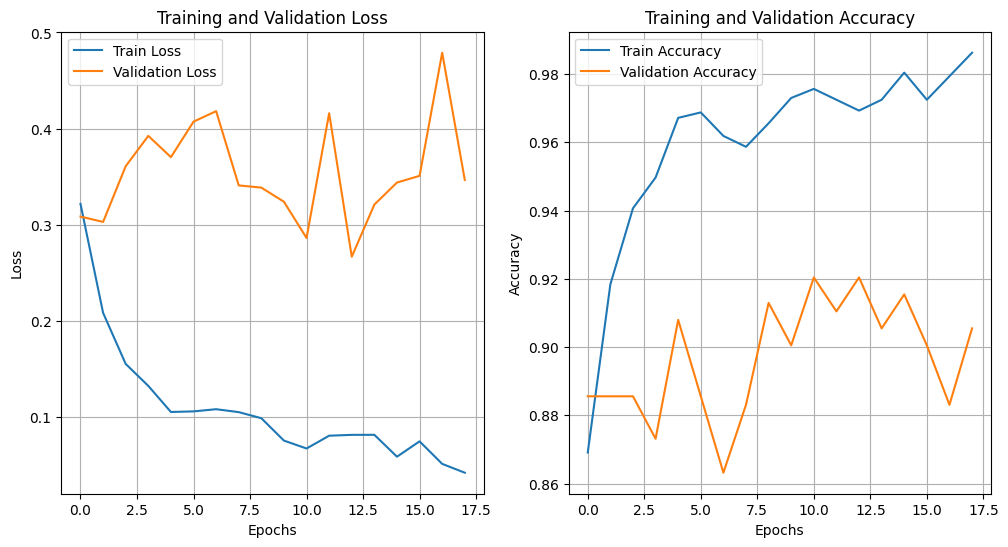

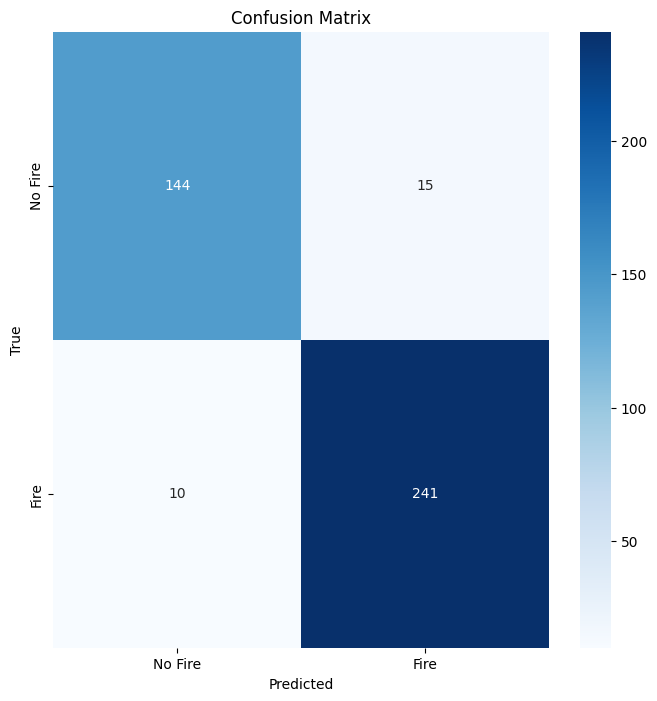

In [11]:
# Evaluation and Visualization
print("[INFO] Evaluating final model...")
metrics = evaluate_model(final_model, test_loader, ["No Fire", "Fire"], device, model_name="mobilenet_v2", save_base_path="outputs/plots/tuned/mobilenet_v2")
# Training and Validation Curves
plot_training(history, f"outputs/plots/tuned/mobilenetv2_tuned_training_curve.png")

# Confusion Matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=f"outputs/plots/tuned/mobilenetv2_tuned_confusion_matrix.png"
)

# Precision-Recall Curve
if "y_probs" in metrics:
    y_true = metrics["y_true"]
    y_probs = [prob[1] for prob in metrics["y_probs"]]
    plot_precision_recall(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/plots/tuned/mobilenetv2_tuned_precision_recall_curve.png"
    )

    # ROC Curve
    plot_roc_curve(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/plots/tuned/mobilenetv2_tuned_roc_curve.png"
    )

print("[INFO] All results saved successfully!")